### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_fbk_v1.csv"
df = pd.read_csv(dataset)



In [3]:
df["LargeText"] = df["LinkText"]+" "+df["Message"]

In [4]:
noticias = df.LargeText
len(noticias)

4656

In [5]:
import re
# Remove Emails
noticias = [re.sub(r'\S*@\S*\s?', '', sent) for sent in noticias]

# Remove new line characters
noticias = [re.sub(r'\s+', ' ', sent) for sent in noticias]

# Remove distracting single quotes
noticias= [re.sub("\'", "", sent) for sent in noticias]

# Remove links
noticias = [re.sub(r'\S*http\S*\s?', '', sent) for sent in noticias]
noticias = [re.sub(r'\S*https\S*\s?', '', sent) for sent in noticias]


In [6]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [7]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [8]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [9]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [10]:
print(diccionario)

['virus', 'gabriel', 'momento', 'muerte', 'hablar', 'internacional', 'acusar', 'afirmar', 'jorge', 'relacionado', 'apoyar', 'identificar', 'sanitario', 'historia', 'vacuna', 'criticar', 'whatsapp', 'poder', 'médico', 'desmentir', 'organización', 'autoridad', 'voz', 'servicio', 'ministerio', 'jefe', 'rumor', 'descartar', 'campaña', 'estrategia', 'diputada', 'corte', 'alcalde', 'juan', 'mantener', 'oficial', 'llevar', 'declarar', 'republicano', 'clinic', 'recibir', 'casa', 'tema', 'dicho', 'publicación', 'región', 'forma', 'internet', 'ministro', 'defender', 'kast', 'convención', 'afectar', 'polémico', 'mundo', 'hecho', 'coronavirus', 'sancionar', 'nombre', 'aparecer', 'constituyente', 'trump', 'difusión', 'entrega', 'ver', 'derecho', 'proceso', 'ojo', 'boric', 'presunto', 'rusia', 'vivir', 'permitir', 'relación', 'vía', 'llegar', 'reconocer', 'cnn', 'evitar', 'periodista', 'piñera', 'gobierno', 'población', 'derecha', 'uu', 'carrera', 'falso', 'haber', 'electoral', 'denuncia', 'delito',

In [11]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,10)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=200,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



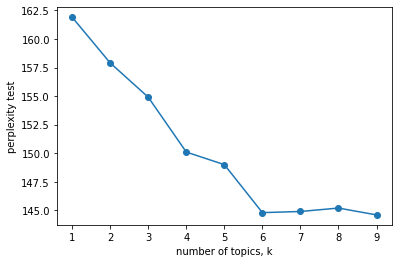

In [12]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [16]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=6,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [15]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=6
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['desinformación', 'él', 'campaña', 'gobierno', 'pandemia', 'país', 'proceso', 'medio', 'política', 'comunicación', 'chile', 'periodismo', 'tiempo', 'nacional', 'salud', 'año', 'opinión', 'experto', 'piñera', 'crisis'], ['fake', 'new', 'empty', 'trump', 'video', 'bolsonaro', 'desmentir', 'presidente', 'news', 'brasil', 'periodista', 'the', 'publicar', 'mandatario', 'foto', 'imagen', 'donald', 'twitter', 'online', 'cnn'], ['falso', 'información', 'incendio', 'entregar', 'acusar', 'difundir', 'caso', 'pedir', 'carabinero', 'supuesto', 'aclarar', 'denunciar', 'noticia', 'fiscalía', 'desmentir', 'gobierno', 'haber', 'investigar', 'ex', 'investigación'], ['social', 'red', 'falso', 'facebook', 'noticia', 'información', 'circular', 'whatsapp', 'coronavirus', 'mensaje', 'desinformación', 'twitter', 'plataforma', 'usuario', 'contenido', 'evitar', 'cuenta', 'combatir', 'dato', 'medida'], ['fake', 'new', 'chile', 'empty', 'boric', 'kast', 'acusar', 'diputado', 'carrera', 'gonzalo', 'campaña', 'p

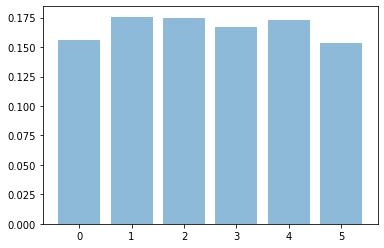

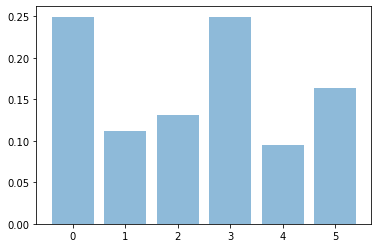

[0.034099862, 0.02923207, 0.02700283, 0.026112324, 0.015984746, 0.009535664, 0.009124484, 0.00912299, 0.008973818, 0.008568436, 0.007725818, 0.0076631713, 0.0073719984, 0.0066907816, 0.006666196]


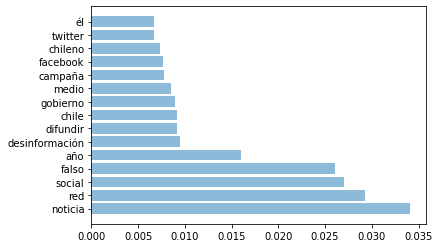

[0.21358728, 0.19090013, 0.062217727, 0.040583294, 0.018216787, 0.014766774, 0.012476467, 0.012441611, 0.0119096935, 0.011458476, 0.010217763, 0.008164166, 0.007192037, 0.0069497265, 0.006585084]


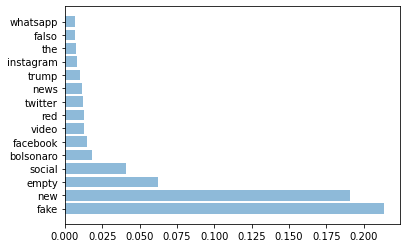

[0.19575574, 0.114573434, 0.09696334, 0.020175515, 0.016155507, 0.015990788, 0.015488717, 0.014157936, 0.011136929, 0.0082989875, 0.0075428523, 0.007489426, 0.0066077015, 0.0062578446, 0.005899608]


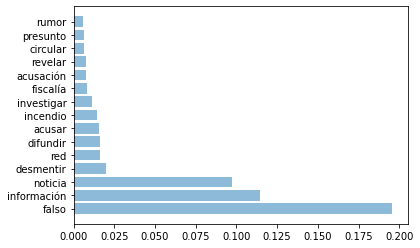

[0.08909642, 0.03644612, 0.030833611, 0.022670066, 0.017598739, 0.0121422075, 0.010695043, 0.010085097, 0.009546069, 0.008754623, 0.008122573, 0.008099079, 0.008084421, 0.0077235424, 0.007593863]


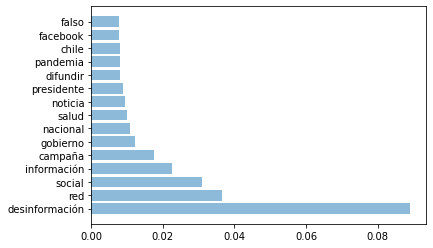

[0.075205274, 0.06335597, 0.046309907, 0.038077403, 0.026153091, 0.025470693, 0.019408079, 0.018801896, 0.016556688, 0.01523974, 0.013756532, 0.011927322, 0.010726518, 0.010138943, 0.009319075]


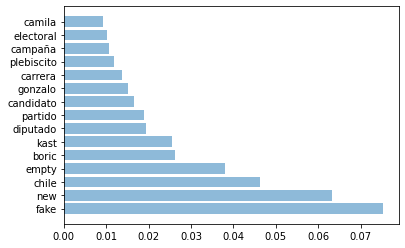

[0.12083794, 0.09121805, 0.024306927, 0.013204817, 0.011846383, 0.011045211, 0.010369315, 0.009794273, 0.008269704, 0.007511708, 0.0074892957, 0.006864689, 0.0067817625, 0.006763889, 0.0066539305]


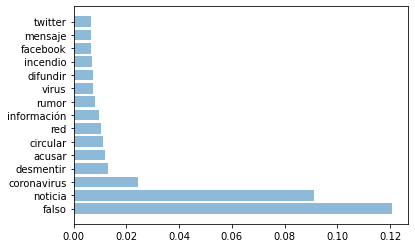

In [24]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [17]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [19]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

In [20]:
topic_coherence = etm_instance.get_topic_coherence()

print(topic_coherence)

topic_diversity = etm_instance.get_topic_diversity()

print(topic_diversity)

print(etm_instance._perplexity(test_dataset))



0.09447463785046083
0.84
141.9


/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its